Import necessary libraries and packages

In [3]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
from xmitgcm import llcreader
from matplotlib import pyplot as plt
import cmocean.cm as cm
import gcm_filters
import zarr

%matplotlib inline

Import the data we want to handle

In [4]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

In [5]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
ssh = cat.LLC4320_SSH.to_dask()

/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [6]:
ds = xr.merge([sst,ssh])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)
# Get data on a single face 
ds_face = xr.merge([ssh.sel(face=1), sst.sel(face=1)])

# Get coordiantes from the catalog
coords_face = (cat.LLC4320_grid.to_dask()).sel(face=1)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xmitgcm/llcreader/llcmodel.py:322: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(ifac * coords.dims[vname])
/srv/conda/envs/notebook/lib/python3.11/site-packages/xmitgcm/llcreader/llcmodel.py:324: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  data = np.arange(jfac * coords.dims[vname])
/srv/conda/envs/notebook/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.

Specify the attributes of the filter we want to apply to our datasets

In [7]:
filter = gcm_filters.Filter(
    filter_scale=16,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR,
    grid_vars={}
)

In [8]:
ds_in_1 = ds.Eta.isel(time=slice(0,9030,120)).isel(i=slice(12000,13280), j=slice(6000,7280))

In [9]:
ds_in_2 = ds.Eta.isel(time=slice(0,9030,120)).isel(i=slice(0,1280), j=slice(4000,5280))

In [10]:
mask1 = (~np.isnan(ds_in_1)).astype('float32')
mask2 = (~np.isnan(ds_in_2)).astype('float32')

In [11]:
filter_masked1 = gcm_filters.Filter(
    filter_scale=16,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': mask1.chunk({'i':-1,'j':-1})}
)

In [12]:
filter_masked2 = gcm_filters.Filter(
    filter_scale=16,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': mask2.chunk({'i':-1,'j':-1})}
)

Filter the data and then compute it so we can use it 

In [13]:
%time ds_in_1_filtered = filter.apply(ds_in_1.chunk({'i':-1,'j':-1}), dims=['j','i'])

CPU times: user 4.7 ms, sys: 0 ns, total: 4.7 ms
Wall time: 4.67 ms


In [14]:
%time ds_in_2_filtered = filter.apply(ds_in_2.chunk({'i':-1,'j':-1}), dims=['j','i'])

CPU times: user 3.71 ms, sys: 0 ns, total: 3.71 ms
Wall time: 3.67 ms


In [14]:
ds_in_1_filtered.compute()

<xarray.DataArray 'Eta' (time: 76, j: 1280, i: 1280)> Size: 498MB
array([[[0.73068637, 0.6915697 , 0.6551247 , ..., 0.8465923 ,
         0.8100367 , 0.7708533 ],
        [0.64993733, 0.6123326 , 0.57730794, ..., 0.76141393,
         0.72625   , 0.6885656 ],
        [0.57464695, 0.53844696, 0.5047441 , ..., 0.68201494,
         0.6481409 , 0.6118469 ],
        ...,
        [0.9692552 , 0.9257493 , 0.88518333, ..., 1.0980408 ,
         1.057434  , 1.0138922 ],
        [0.89415085, 0.85200435, 0.8127149 , ..., 1.0189412 ,
         0.9795919 , 0.9374017 ],
        [0.8134991 , 0.77284086, 0.7349481 , ..., 0.93392044,
         0.8959456 , 0.85523343]],

       [[0.61298096, 0.593972  , 0.5761735 , ..., 0.6681797 ,
         0.651009  , 0.632338  ],
        [0.5780114 , 0.5574363 , 0.53820884, ..., 0.63795036,
         0.6192751 , 0.59899724],
        [0.5455765 , 0.52354944, 0.50299364, ..., 0.609903  ,
         0.58983546, 0.5680709 ],
...
        [1.2427896 , 1.1740252 , 1.1097906 , ..., 1.4455683 ,
         1.3817594 , 1.3132097 ],
        [1.1623024 , 1.0946367 , 1.031458  , ..., 1.3619695 ,
         1.2991215 , 1.2316244 ],
        [1.0758574 , 1.0094137 , 0.947416  , ..., 1.272139  ,
         1.2103215 , 1.1439697 ]],

       [[0.6706363 , 0.6817196 , 0.6923051 , ..., 0.63866675,
         0.648676  , 0.6594592 ],
        [0.6507892 , 0.6613173 , 0.6713722 , ..., 0.62048113,
         0.6299527 , 0.6401772 ],
        [0.63243663, 0.6424861 , 0.6520798 , ..., 0.60354364,
         0.6125596 , 0.62230855],
        ...,
        [0.73047024, 0.74345404, 0.75581956, ..., 0.69270647,
         0.7046001 , 0.7173353 ],
        [0.71138495, 0.72372335, 0.7354913 , ..., 0.6756113 ,
         0.68685585, 0.6989202 ],
        [0.69117   , 0.7028658 , 0.7140316 , ..., 0.6573529 ,
         0.66796154, 0.67936647]]], dtype=float32)
Coordinates:
  * i        (i) int64 10kB 12000 12001 12002 12003 ... 13276 13277 13278 13279
  * j        (j) int64 10kB 6000 6001 6002 6003 6004 ... 7276 7277 7278 7279
  * time     (time) datetime64[ns] 608B 2011-09-13 2011-09-18 ... 2012-09-22

In [15]:
ds_in_2_filtered.compute()

<xarray.DataArray 'Eta' (time: 76, j: 1280, i: 1280)> Size: 498MB
array([[[-1.3238728 , -1.3402846 , -1.354288  , ..., -1.2713374 ,
         -1.2881961 , -1.3060621 ],
        [-1.5150597 , -1.5309078 , -1.544263  , ..., -1.4641199 ,
         -1.4804189 , -1.49777   ],
        [-1.6915991 , -1.7069138 , -1.7196714 , ..., -1.6422156 ,
         -1.6579678 , -1.6748155 ],
        ...,
        [-0.75196296, -0.76975614, -0.7854425 , ..., -0.6957562 ,
         -0.7139106 , -0.7329588 ],
        [-0.93286407, -0.95029646, -0.96552014, ..., -0.87756693,
         -0.89539754, -0.9141536 ],
        [-1.1263304 , -1.143289  , -1.1579357 , ..., -1.0722948 ,
         -1.0896802 , -1.1080296 ]],

       [[-1.1175146 , -1.0900404 , -1.064729  , ..., -1.2009001 ,
         -1.1742687 , -1.1460718 ],
        [-1.2449049 , -1.217594  , -1.1924394 , ..., -1.3279126 ,
         -1.3013805 , -1.2733107 ],
        [-1.3629668 , -1.3356274 , -1.3104306 , ..., -1.4460447 ,
         -1.4194893 , -1.391395  ],
...
        [-0.36549047, -0.3654555 , -0.3659248 , ..., -0.36855236,
         -0.367086  , -0.36606735],
        [-0.50597066, -0.5017136 , -0.49832898, ..., -0.52200425,
         -0.51635635, -0.51094866],
        [-0.65745234, -0.64848953, -0.6408023 , ..., -0.68789184,
         -0.6776118 , -0.6673263 ]],

       [[-1.1165687 , -1.0764579 , -1.0389655 , ..., -1.2360703 ,
         -1.1981515 , -1.157788  ],
        [-1.2802999 , -1.2426124 , -1.2073685 , ..., -1.3930387 ,
         -1.3571324 , -1.3190651 ],
        [-1.4301827 , -1.3950845 , -1.3622651 , ..., -1.5357516 ,
         -1.5019783 , -1.4663446 ],
        ...,
        [-0.62133497, -0.57526433, -0.53237987, ..., -0.7580122 ,
         -0.7148967 , -0.6686926 ],
        [-0.77867264, -0.7343593 , -0.6930384 , ..., -0.9101711 ,
         -0.86864173, -0.8242004 ],
        [-0.9462788 , -0.9039529 , -0.86442775, ..., -1.0720425 ,
         -1.0322481 , -0.9897572 ]]], dtype=float32)
Coordinates:
  * i        (i) int64 10kB 0 1 2 3 4 5 6 ... 1273 1274 1275 1276 1277 1278 1279
  * j        (j) int64 10kB 4000 4001 4002 4003 4004 ... 5276 5277 5278 5279
  * time     (time) datetime64[ns] 608B 2011-09-13 2011-09-18 ... 2012-09-22

In [15]:
%time ds_in_1_filtered_masked = filter_masked1.apply(ds_in_1.chunk({'i':-1,'j':-1}), dims=['j','i'])

CPU times: user 4.57 ms, sys: 0 ns, total: 4.57 ms
Wall time: 4.49 ms


In [16]:
%time ds_in_2_filtered_masked = filter_masked2.apply(ds_in_2.chunk({'i':-1,'j':-1}), dims=['j','i'])

CPU times: user 5 ms, sys: 0 ns, total: 5 ms
Wall time: 4.92 ms


In [17]:
smaller_datasets1_unfiltered = []
smaller_datasets1_filtered = []


original_i_size1 = ds_in_1.to_dataset().dims['i']
original_j_size1 = ds_in_1.to_dataset().dims['j']

# Iterate over the entire dataset to create smaller subsets
for i_start in range(0, original_i_size1, 128):
    for j_start in range(0, original_j_size1, 128):
        # Calculate the end indices for slicing
        i_end = min(i_start + 128, original_i_size1)  # Ensure i_end does not exceed 13279
        j_end = min(j_start + 128, original_j_size1)   # Ensure j_end does not exceed 7279

        
        # Subset the dataset
        ds_filtered_subset1 = ds_in_1_filtered_masked.isel(time=slice(0,76), i=slice(i_start, i_end, 4), j=slice(j_start, j_end, 4))
        ds_filtered_subset1 = ds_filtered_subset1.drop_vars(['i','j'])  
        
        # Append the subsets to the respective lists
        smaller_datasets1_filtered.append(ds_filtered_subset1)


/tmp/ipykernel_416/3465829494.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_i_size1 = ds_in_1.to_dataset().dims['i']
/tmp/ipykernel_416/3465829494.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_j_size1 = ds_in_1.to_dataset().dims['j']


In [18]:
for i_start in range(0, original_i_size1, 128):
    for j_start in range(0, original_j_size1, 128):
        # Calculate the end indices for slicing
        i_end = min(i_start + 128, original_i_size1)  # Ensure i_end does not exceed 13279
        j_end = min(j_start + 128, original_j_size1)   # Ensure j_end does not exceed 7279

        
        # Subset the dataset
        ds_unfiltered_subset1 = ds_in_1.isel(time=slice(0,76), i=slice(i_start, i_end), j=slice(j_start, j_end))
        ds_unfiltered_subset1 = ds_unfiltered_subset1.drop_vars(['i','j']) 
        
        # Append the subsets to the respective lists
        smaller_datasets1_unfiltered.append(ds_unfiltered_subset1)

We do the exact same thing with our second dataset

In [19]:
smaller_datasets2_unfiltered = []
smaller_datasets2_filtered = []

original_i_size2 = ds_in_2.to_dataset().dims['i']
original_j_size2 = ds_in_2.to_dataset().dims['j']

# Iterate over the entire dataset to create smaller subsets
for i_start in range(0, original_i_size2, 128):
    for j_start in range(0, original_j_size2, 128):
        # Calculate the end indices for slicing
        i_end = min(i_start + 128, original_i_size2)  # Ensure i_end does not exceed 13279
        j_end = min(j_start + 128, original_j_size2)   # Ensure j_end does not exceed 7279

        # Subset the dataset
        ds_filtered_subset2 = ds_in_2_filtered_masked.isel(time=slice(0,76), i=slice(i_start, i_end, 4), j=slice(j_start, j_end, 4))
        ds_filtered_subset2 = ds_filtered_subset2.drop_vars(['i','j'])
        
        # Append the subsets to the respective lists
        smaller_datasets2_filtered.append(ds_filtered_subset2)

/tmp/ipykernel_416/2232230939.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_i_size2 = ds_in_2.to_dataset().dims['i']
/tmp/ipykernel_416/2232230939.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  original_j_size2 = ds_in_2.to_dataset().dims['j']


In [24]:
for i_start in range(0, original_i_size2, 128):
    for j_start in range(0, original_j_size2, 128):
        # Calculate the end indices for slicing
        i_end = min(i_start + 128, original_i_size2)  # Ensure i_end does not exceed 13279
        j_end = min(j_start + 128, original_j_size2)   # Ensure j_end does not exceed 7279

        # Subset the dataset
        ds_unfiltered_subset2 = ds_in_2.isel(time=slice(0,76), i=slice(i_start, i_end), j=slice(j_start, j_end))
        ds_unfiltered_subset2 = ds_unfiltered_subset2.drop_vars(['i','j'])
        
        # Append the subsets to the respective lists
        smaller_datasets2_unfiltered.append(ds_unfiltered_subset2)

Now we convert the filtered and unfiltered lists for each dataset into DataArray objects for easier storage and access

In [21]:
ds2_filtered = xr.concat(smaller_datasets2_filtered, dim='dataset2_small')

In [22]:
ds2_unfiltered = xr.concat(smaller_datasets2_unfiltered, dim='dataset2_large')

In [26]:
ds1_filtered = xr.concat(smaller_datasets1_filtered, dim='dataset1_small')

In [27]:
ds1_unfiltered = xr.concat(smaller_datasets1_unfiltered, dim='dataset1_large')

In [36]:
user_path = "gs://leap-persistent/funky-user"  # 👀 make sure to prepend `gs://` to the path or xarray will interpret this as a local path
store_name = "ds1_filtered_32.zarr"
ds1_filtered.to_zarr(f"{user_path}/{store_name}")

In [37]:
store_name = "ds1_unfiltered_128.zarr"
ds1_unfiltered.to_zarr(f"{user_path}/{store_name}")

In [46]:
store_name = "ds2_filtered_32.zarr"
ds2_filtered.to_zarr(f"{user_path}/{store_name}")

In [49]:
store_name = "ds2_unfiltered_128.zarr"
ds2_unfiltered.to_zarr(f"{user_path}/{store_name}")

In [50]:
ds2_128 = xr.open_dataset(
    "gs://leap-persistent/funky-user/ds2_unfiltered_128.zarr", engine="zarr", chunks={}
)
ds2_128

<xarray.Dataset> Size: 498MB
Dimensions:  (dataset2_large: 100, time: 76, j: 128, i: 128)
Coordinates:
  * time     (time) datetime64[ns] 608B 2011-09-13 2011-09-18 ... 2012-09-22
Dimensions without coordinates: dataset2_large, j, i
Data variables:
    Eta      (dataset2_large, time, j, i) float32 498MB dask.array<chunksize=(1, 1, 64, 128), meta=np.ndarray>

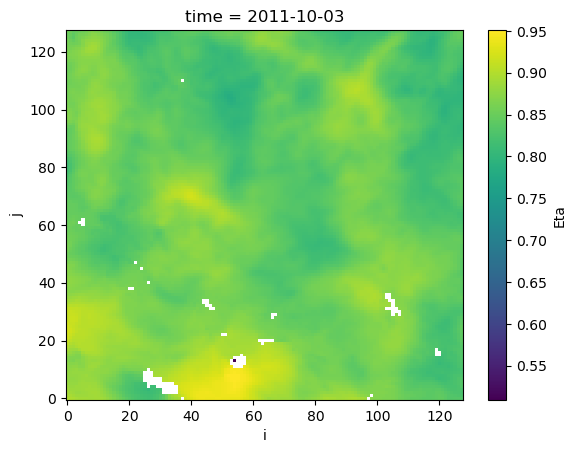

In [33]:
ds1_unfiltered.isel(dataset1_large=18).isel(time=4).plot()

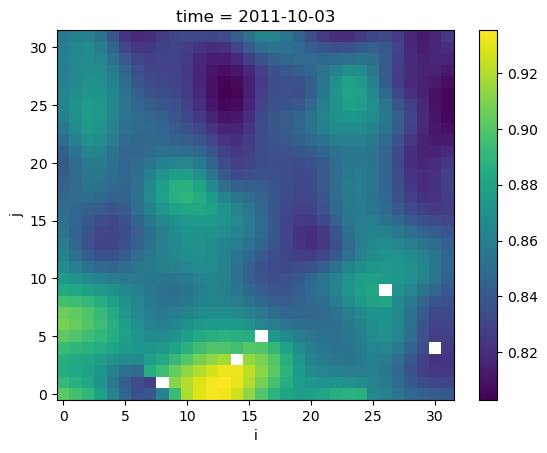

In [34]:
ds1_filtered.isel(dataset1_small=18).isel(time=4).plot()